In [1]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv(r"C:\Users\nice\Desktop\sales-forecasting-project (1)\sales-forecasting-project\data\processed\final_data.csv")

In [3]:
df.head(1)

,Date,Inventory Level,Units Sold,Demand Forecast,Holiday/Promotion,Seasonality,Sales,month,Rolling_Mean_7,Rolling_Std_7,Rolling_Mean_30,Rolling_Std_30
0,2022-01-02,416,163,171.6,0,Winter,3209.14,1,117.0,73.952688,120.166667,89.490159


In [4]:
x = df.drop(["Units Sold","Sales","Date"], axis=1)
y = df['Units Sold']

In [5]:
numerical_features = x.select_dtypes(include='number').columns.tolist()
categorical_features = x.select_dtypes(include = 'object').columns.tolist()

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

In [7]:
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=250,learning_rate=0.1,max_depth=6,random_state=42))
    
])

In [8]:
xgb_pipeline.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Inventory Level',
                                                   'Demand Forecast',
                                                   'Holiday/Promotion', 'month',
                                                   'Rolling_Mean_7',
                                                   'Rolling_Std_7',
                                                   'Rolling_Mean_30',
                                                   'Rolling_Std_30']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Seasonality'])])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callback...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=250, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [9]:
y_pred = xgb_pipeline.predict(x_test)

In [10]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

In [11]:
print("xgb Results:")
print("MAE:", mae)
print("R² Score:", r2)
print("RMSE:", rmse)


xgb Results:
MAE: 7.251648426055908
R² Score: 0.9920247197151184
RMSE: 8.49806415728822


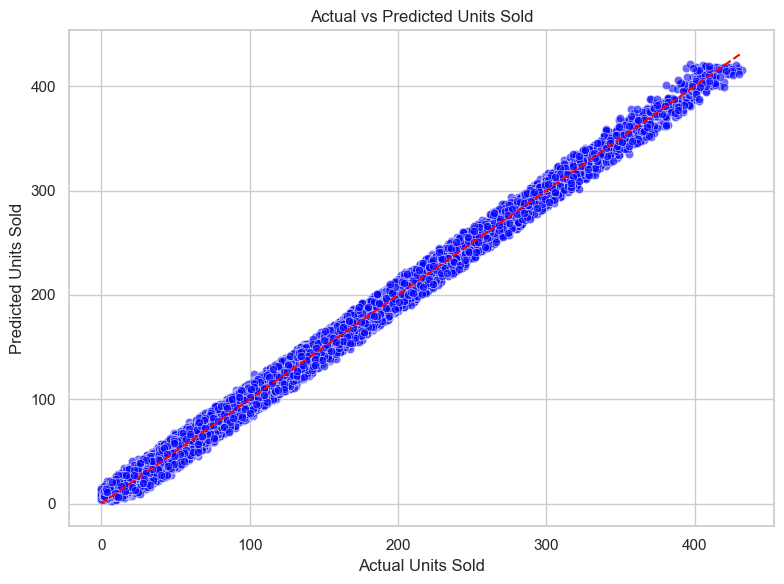

In [12]:
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # Perfect prediction line

# Add labels and title
plt.xlabel("Actual Units Sold")
plt.ylabel("Predicted Units Sold")
plt.title("Actual vs Predicted Units Sold")
plt.tight_layout()
plt.show()

In [13]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
import numpy as np

# إعداد موديل XGBRegressor
xgb_model = XGBRegressor(random_state=42)

# تحديد مجموعة المعاملات الممكن تجربتها
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# إعداد RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,               # عدد التجارب العشوائية
    scoring='neg_mean_absolute_error',  # نستخدم MAE للتقييم
    cv=3,                    # Cross-validation 3 مرات
    verbose=2,
    random_state=42,
    n_jobs=-1                # استخدام جميع الأنوية
)

# تشغيل البحث على بيانات التدريب (بعد ال preprocessor)
x_train_transformed = preprocessor.fit_transform(x_train)
random_search.fit(x_train_transformed, y_train)

# أفضل المعاملات
print("Best parameters found: ", random_search.best_params_)

# أفضل نتيجة (MAE)
print("Best MAE score: ", -random_search.best_score_)

# استخدام أفضل نموذج للتنبؤ
best_model = random_search.best_estimator_
# Preprocess the test data
x_test_transformed = preprocessor.transform(x_test)

# Use the best model to predict
y_pred = best_model.predict(x_test_transformed)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Tuned Model MAE:", mae)
print("Tuned Model RMSE:", rmse)
print("Tuned Model R2:", r2)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


c:\Users\nice\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\nice\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\nice\anaconda3\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\nice\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1222, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
                           ^^

Best parameters found:  {'subsample': 0.6, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Best MAE score:  7.19739309946696
Tuned Model MAE: 7.265298366546631
Tuned Model RMSE: 8.477956574591785
Tuned Model R2: 0.9920623898506165


In [14]:
import joblib
joblib.dump(xgb_pipeline, "xgb_model.pkl")


['xgb_model.pkl']